In [306]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline
import sys
import caffe
import os

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.

RHD_ROOT = '/Users/johmathe/code/enmi/rhd/'
MODEL_DEF = RHD_ROOT + 'rhd_classifier_deploy.prototxt'
MODEL_WEIGHTS = RHD_ROOT + 'rhd_classifier.caffemodel'
LABELS_FILE = RHD_ROOT + 'rhd_classifier_labels.txt'
MEAN_FILE = RHD_ROOT + 'rhd_classifier_mean.npy'
caffe.set_mode_cpu()

net = caffe.Net(MODEL_DEF,      # defines the structure of the model
                MODEL_WEIGHTS,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})



mean-subtracted values: [('B', 55.864888151467312), ('G', 54.420093135617208), ('R', 54.639520131313475)]


(3, 227, 227)
129.683059692
174.099
(3, 227, 227)
[ 0.06275126  0.93501276  0.00223603]
predicted class is: 1


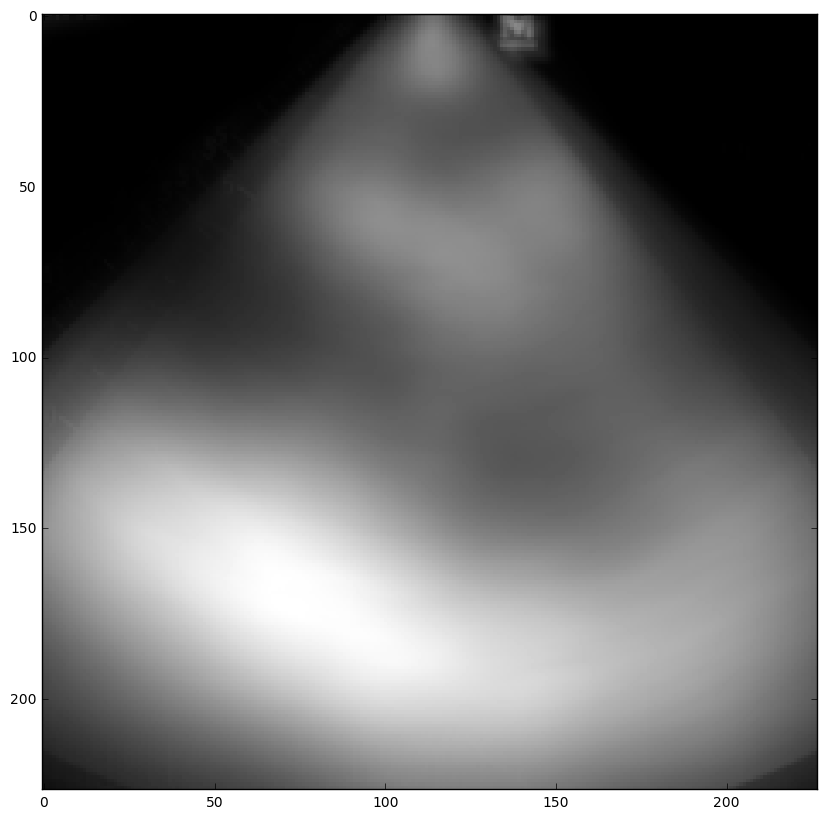

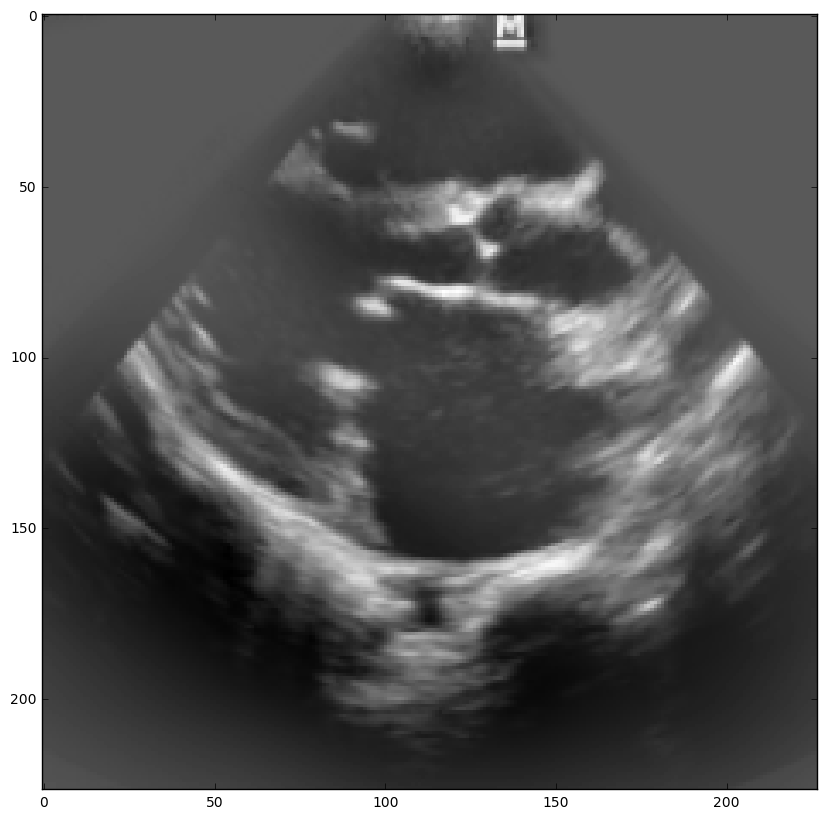

In [305]:
print mean.shape
import scipy
from skimage.transform import resize

def resize_image(im, new_dims, interp_order=1):
    """
    Resize an image array with interpolation.
    Parameters
    ----------
    im : (H x W x K) ndarray
    new_dims : (height, width) tuple of new dimensions.
    interp_order : interpolation order, default is linear.
    Returns
    -------
    im : resized ndarray with shape (new_dims[0], new_dims[1], K)
    """
    if im.shape[-1] == 1 or im.shape[-1] == 3:
        im_min, im_max = im.min(), im.max()
        if im_max > im_min:
            # skimage is fast but only understands {1,3} channel images
            # in [0, 1].
            im_std = (im - im_min) / (im_max - im_min)
            resized_std = resize(im_std, new_dims, order=interp_order)
            resized_im = resized_std * (im_max - im_min) + im_min
        else:
            # the image is a constant -- avoid divide by 0
            ret = np.empty((new_dims[0], new_dims[1], im.shape[-1]),
                           dtype=np.float32)
            ret.fill(im_min)
            return ret
    else:
        # ndimage interpolates anything but more slowly.
        scale = tuple(np.array(new_dims, dtype=float) / np.array(im.shape[:2]))
        resized_im = zoom(im, scale + (1,), order=interp_order)
    return resized_im.astype(np.float32)

mean = np.load(MEAN_FILE)
mean = mean[:, 14:14+227, 14:14+227]
image = caffe.io.load_image(RHD_ROOT + 'rhd_positive.jpg')
image = resize_image(image, (256, 256, 3))[14:14+227, 14:14+227, :]
image = resize_image(image, (256, 256, 3))
plt.imshow(mean[0,:,:])
plt.figure()

transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mean)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR
transformed_image = transformer.preprocess('data', image)
print np.max(mean)
print np.max(transformed_image)
print transformed_image.shape
plt.imshow(transformed_image[0,:,:])

# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image

### perform classification
output = net.forward()

output_prob = output['prob'][0]  # the output probability vector for the first image in the batch
print output_prob

print 'predicted class is:', output_prob.argmax()

In [99]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(1, 3, 227, 227)
conv1	(1, 96, 55, 55)
norm1	(1, 96, 55, 55)
pool1	(1, 96, 27, 27)
conv2	(1, 256, 27, 27)
norm2	(1, 256, 27, 27)
pool2	(1, 256, 13, 13)
conv3	(1, 384, 13, 13)
conv4	(1, 384, 13, 13)
conv5	(1, 256, 13, 13)
pool5	(1, 256, 6, 6)
fc6_rhd	(1, 1024)
fc7_rhd	(1, 1024)
fc8_rhd	(1, 3)
prob	(1, 3)


In [62]:
### perform classification
output = net.forward()

output_prob = output['prob'][0]  # the output probability vector for the first image in the batch
print output_prob.argmax()
print output_prob
labels = np.loadtxt(LABELS_FILE, str, delimiter='\t')
print labels
print 'output label:', labels[output_prob.argmax()]

filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

0
[ 0.37874502  0.34951761  0.2717374 ]
['rhd_negative' 'rhd_positive' 'prosthetic']
output label: rhd_negative


NameError: name 'vis_square' is not defined

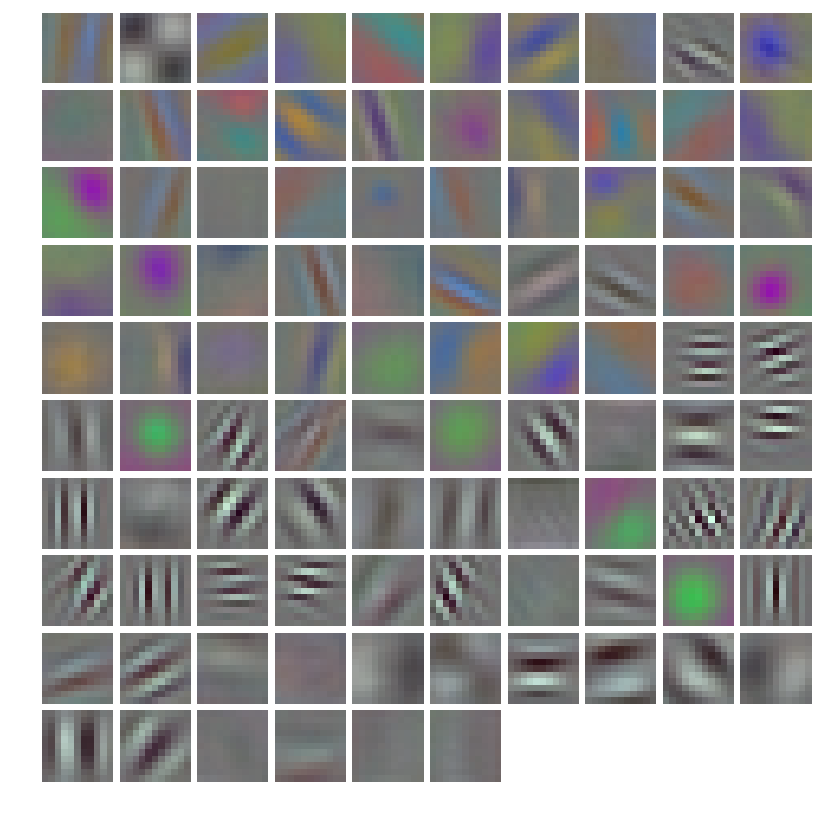

In [100]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

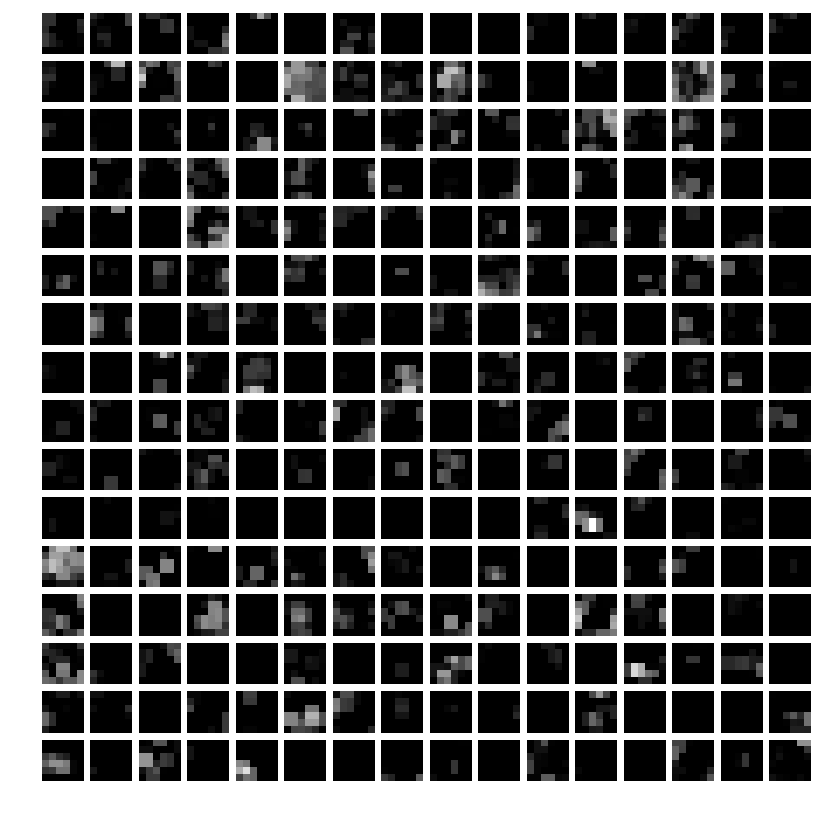

In [102]:
feat = net.blobs['pool5'].data[0]
vis_square(feat)

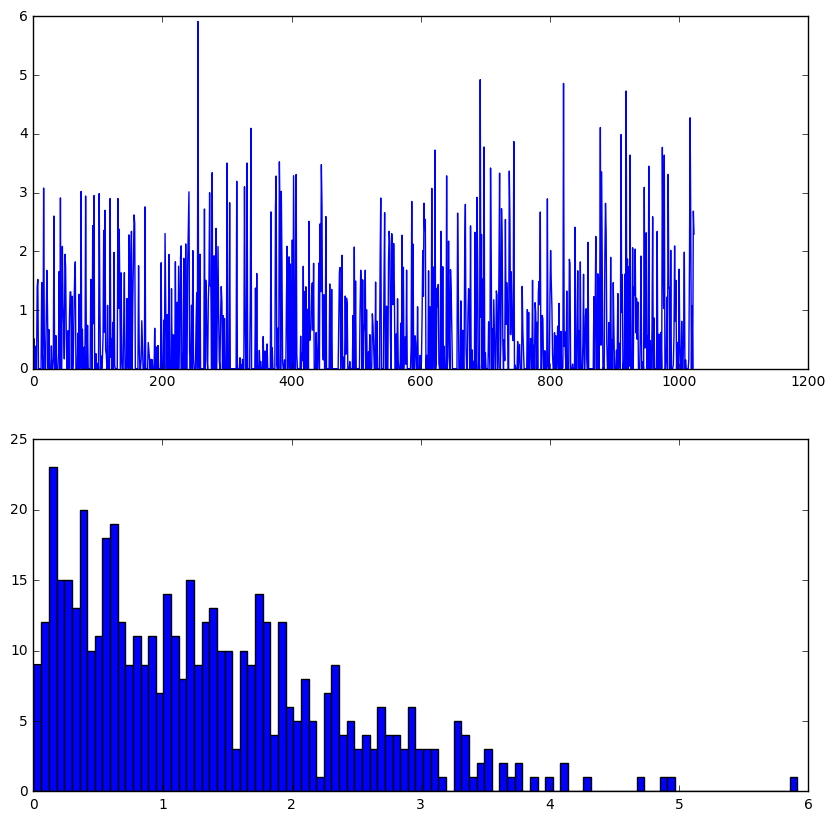

In [105]:
feat = net.blobs['fc7_rhd'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

In [304]:
import math
def heatmap_for_class(net, image, class_id=1, mask_size=16, stride=16):
    """Generates a heatmap of probability given an image with a black square
    of size mask_size being moved every stride pixels."""
    
    _, image_h, image_w = image.shape
    heat_h, heat_w = (int(math.ceil(image_h / float(stride))),
                      int(math.ceil(image_w / float(stride))))
    heatmap_shape = heat_h, heat_w
    images = np.ndarray(shape=(
        (heat_h * heat_w, ) + image.shape)).astype(np.float32)

    i = 0
    print image_h
    print stride
    for h in range(0, image_h, stride):
        for w in range(0, image_w, stride):
            images[i] = np.copy(image)
            # Setting 0 since black is the most probable color.
            images[i][:, max(h - mask_size, 0):h, max(w - mask_size, 0):w] = -121.0
            i += 1
    results = []
    for i in images:
        net.blobs['data'].data[...] = i
        output = net.forward()
        results.append(output['prob'][0][class_id])
    return np.asarray(results).reshape(heatmap_shape)

print np.max(transformed_image)
print np.min(transformed_image)

my_heat = heatmap_for_class(net, transformed_image)
print my_heat

174.099
-121.502
227
16
[[ 0.93501276  0.93501276  0.93501276  0.93501276  0.93501276  0.93501276
   0.93501276  0.93501276  0.93501276  0.93501276  0.93501276  0.93501276
   0.93501276  0.93501276  0.93501276]
 [ 0.93501276  0.93204498  0.93340158  0.90734923  0.88713485  0.87892425
   0.84582174  0.86273509  0.86539787  0.86707914  0.91297799  0.92320275
   0.92005187  0.9129476   0.91837752]
 [ 0.93501276  0.91419196  0.87790585  0.84422177  0.81924599  0.86623073
   0.83384216  0.88384163  0.91288888  0.93690217  0.92535144  0.88308042
   0.93098897  0.90428638  0.92094886]
 [ 0.93501276  0.88418221  0.84147507  0.8237226   0.86082244  0.81539565
   0.89263546  0.90722424  0.82286733  0.89166206  0.8942607   0.87206584
   0.89832401  0.92256939  0.93417495]
 [ 0.93501276  0.88704568  0.88515335  0.86272836  0.82016355  0.84949106
   0.89492995  0.92628258  0.85586637  0.94329113  0.91734326  0.92859894
   0.94831592  0.96185511  0.96973014]
 [ 0.93501276  0.93775094  0.91847557  0.

0.99347448349
0.0
(227, 227)
1.32618880129
0.0
(227, 227, 3)


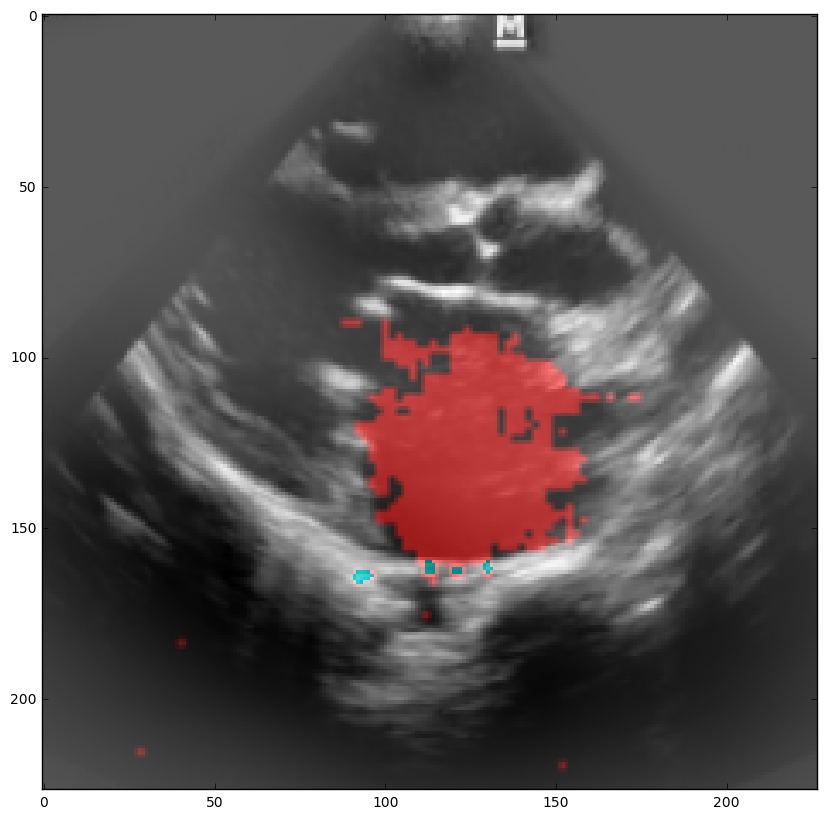

In [302]:
transformed_image = transformer.preprocess('data', image)
new_image = np.ndarray((227,227,3))
img_min = np.min(transformed_image)
img_delta = np.max(transformed_image) - img_min
new_image[:,:,0] = (transformed_image[0,:,:] - img_min) / img_delta
new_image[:,:,1] = (transformed_image[0,:,:] - img_min) / img_delta
new_image[:,:,2] = (transformed_image[0,:,:] - img_min) / img_delta 
print np.max(new_image)
print np.min(new_image)

plt.imshow(new_image)
heatmap = np.load(RHD_ROOT + 'heatmap.npy')
new_heatmap = np.ndarray((114,114))
TH = 0.80
new_heatmap[heatmap > TH] = 0.0
new_heatmap[heatmap <= TH] = 0.70
resized = scipy.misc.imresize(new_heatmap, (227,227)) / 500.0
print resized.shape

new_image[:,:,0] += resized
print np.max(new_image)
print np.min(new_image)
plt.imshow(new_image)
print new_image.shape
